In [25]:
!pip install --upgrade accelerate
!pip install -q evaluate
!pip install -q albumentations

In [26]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 1.1 MB/s eta 0:00:0000:0100:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=7736301896995023b4b3f5a094a1d255ef4b1ffb52c6ad3e2448e92e34104c07
  Stored in directory: /Users/agatapolejowska/Library/Caches/pip/wheels/5d/90/92/0661d038b2e6ce71cad21432f92c50b1d79887bd5eb82ff3b1
Successfully built grad-cam


## ML

In [1]:
from datasets import load_dataset


dataset = load_dataset("imagefolder", data_dir="../NCT-CRC-HE-small-5k-per-class")

Resolving data files:   0%|          | 0/45000 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/agatapolejowska/.cache/huggingface/datasets/imagefolder/default-55ddf54227fa68d5/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
dataset

DatasetDict({
    test: Dataset({
        features: ['image'],
        num_rows: 1
    })
})

In [2]:
model_checkpoint = "microsoft/resnet-50"
batch_size = 32

In [3]:
import evaluate

metric = evaluate.load("accuracy")

In [4]:
example = dataset["train"][10]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 0}

In [5]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'], id=None)}

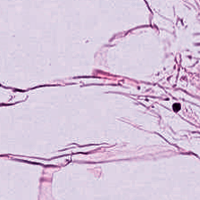

In [6]:
example['image'].resize((200, 200))

In [7]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'DEB'

In [8]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/opt/miniconda3/envs/vicellst-detr/lib/python3.11/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [9]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [10]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([9, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [12]:
import torch

def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        image = np.moveaxis(example["pixel_values"], source=2, destination=0)
        images.append(torch.from_numpy(image))
        labels.append(example["label"])
        
    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "labels": labels}

In [13]:
import cv2
import albumentations as A
import numpy as np

if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = A.Compose([
    A.Resize(height=size, width=size),
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
])

val_transforms = A.Compose([
    A.Resize(height=size, width=size),
    A.Normalize(),
])

def preprocess_train(examples):
    examples["pixel_values"] = [
        train_transforms(image=np.array(image))["image"] for image in examples["image"]
    ]

    return examples

def preprocess_val(examples):
    examples["pixel_values"] = [
        val_transforms(image=np.array(image))["image"] for image in examples["image"]
    ]

    return examples

In [14]:
splits = dataset["train"].train_test_split(test_size=0.3)
train_ds = splits['train']
val_ds = splits['test']

In [15]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [18]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-nct-crc-he-45k",
    hub_model_id=f"{model_name}-finetuned-nct-crc-he-45k",
    use_mps_device=True,
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/polejowska/resnet-50-finetuned-nct-crc-he-45k into local empty directory.


In [20]:
train_results = trainer.train()

# resume training from checkpoint
# train_results = trainer.train(resume_from_checkpoint=True)

# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/miniconda3/envs/vicellst-detr/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin


  0%|          | 0/2460 [00:00<?, ?it/s]

{'loss': 2.1969, 'learning_rate': 2.0325203252032523e-06, 'epoch': 0.04}
{'loss': 2.1951, 'learning_rate': 4.0650406504065046e-06, 'epoch': 0.08}
{'loss': 2.1913, 'learning_rate': 6.0975609756097564e-06, 'epoch': 0.12}
{'loss': 2.1895, 'learning_rate': 8.130081300813009e-06, 'epoch': 0.16}
{'loss': 2.1836, 'learning_rate': 1.016260162601626e-05, 'epoch': 0.2}
{'loss': 2.1768, 'learning_rate': 1.2195121951219513e-05, 'epoch': 0.24}
{'loss': 2.1733, 'learning_rate': 1.4227642276422764e-05, 'epoch': 0.28}
{'loss': 2.163, 'learning_rate': 1.6260162601626018e-05, 'epoch': 0.32}
{'loss': 2.1542, 'learning_rate': 1.8292682926829268e-05, 'epoch': 0.37}
{'loss': 2.14, 'learning_rate': 2.032520325203252e-05, 'epoch': 0.41}
{'loss': 2.1289, 'learning_rate': 2.2357723577235773e-05, 'epoch': 0.45}
{'loss': 2.1166, 'learning_rate': 2.4390243902439026e-05, 'epoch': 0.49}
{'loss': 2.0928, 'learning_rate': 2.642276422764228e-05, 'epoch': 0.53}
{'loss': 2.074, 'learning_rate': 2.8455284552845528e-05, 'e

  0%|          | 0/422 [00:00<?, ?it/s]

{'eval_loss': 1.5909837484359741, 'eval_accuracy': 0.8181481481481482, 'eval_runtime': 67.4499, 'eval_samples_per_second': 200.149, 'eval_steps_per_second': 6.256, 'epoch': 1.0}
{'loss': 1.5696, 'learning_rate': 4.9909665763324305e-05, 'epoch': 1.02}
{'loss': 1.4634, 'learning_rate': 4.9683830171635054e-05, 'epoch': 1.06}
{'loss': 1.416, 'learning_rate': 4.9457994579945803e-05, 'epoch': 1.1}
{'loss': 1.3217, 'learning_rate': 4.9232158988256546e-05, 'epoch': 1.14}
{'loss': 1.2045, 'learning_rate': 4.90063233965673e-05, 'epoch': 1.18}
{'loss': 1.1363, 'learning_rate': 4.878048780487805e-05, 'epoch': 1.22}
{'loss': 1.0815, 'learning_rate': 4.85546522131888e-05, 'epoch': 1.26}
{'loss': 0.9954, 'learning_rate': 4.832881662149955e-05, 'epoch': 1.3}
{'loss': 0.9194, 'learning_rate': 4.81029810298103e-05, 'epoch': 1.34}
{'loss': 0.8599, 'learning_rate': 4.787714543812105e-05, 'epoch': 1.38}
{'loss': 0.7447, 'learning_rate': 4.7651309846431805e-05, 'epoch': 1.42}
{'loss': 0.7155, 'learning_rate

  0%|          | 0/422 [00:00<?, ?it/s]

{'eval_loss': 0.24919094145298004, 'eval_accuracy': 0.9397037037037037, 'eval_runtime': 65.1072, 'eval_samples_per_second': 207.35, 'eval_steps_per_second': 6.482, 'epoch': 2.0}
{'loss': 0.314, 'learning_rate': 4.4263775971093045e-05, 'epoch': 2.03}
{'loss': 0.3214, 'learning_rate': 4.4037940379403794e-05, 'epoch': 2.07}
{'loss': 0.2909, 'learning_rate': 4.381210478771455e-05, 'epoch': 2.11}
{'loss': 0.3062, 'learning_rate': 4.35862691960253e-05, 'epoch': 2.15}
{'loss': 0.285, 'learning_rate': 4.336043360433605e-05, 'epoch': 2.19}
{'loss': 0.285, 'learning_rate': 4.313459801264679e-05, 'epoch': 2.23}
{'loss': 0.3238, 'learning_rate': 4.290876242095754e-05, 'epoch': 2.27}
{'loss': 0.2931, 'learning_rate': 4.26829268292683e-05, 'epoch': 2.31}
{'loss': 0.2801, 'learning_rate': 4.2457091237579046e-05, 'epoch': 2.36}
{'loss': 0.2735, 'learning_rate': 4.2231255645889795e-05, 'epoch': 2.4}
{'loss': 0.264, 'learning_rate': 4.2005420054200545e-05, 'epoch': 2.44}
{'loss': 0.2819, 'learning_rate'

  0%|          | 0/422 [00:00<?, ?it/s]

{'eval_loss': 0.14620520174503326, 'eval_accuracy': 0.9613333333333334, 'eval_runtime': 63.7413, 'eval_samples_per_second': 211.794, 'eval_steps_per_second': 6.621, 'epoch': 3.0}
{'loss': 0.2047, 'learning_rate': 3.884372177055104e-05, 'epoch': 3.01}
{'loss': 0.2095, 'learning_rate': 3.861788617886179e-05, 'epoch': 3.05}
{'loss': 0.2386, 'learning_rate': 3.839205058717254e-05, 'epoch': 3.09}
{'loss': 0.2231, 'learning_rate': 3.816621499548329e-05, 'epoch': 3.13}
{'loss': 0.266, 'learning_rate': 3.794037940379404e-05, 'epoch': 3.17}
{'loss': 0.2006, 'learning_rate': 3.771454381210479e-05, 'epoch': 3.21}
{'loss': 0.22, 'learning_rate': 3.7488708220415545e-05, 'epoch': 3.25}
{'loss': 0.2141, 'learning_rate': 3.726287262872629e-05, 'epoch': 3.29}
{'loss': 0.2272, 'learning_rate': 3.7037037037037037e-05, 'epoch': 3.33}
{'loss': 0.2145, 'learning_rate': 3.6811201445347786e-05, 'epoch': 3.37}
{'loss': 0.2155, 'learning_rate': 3.6585365853658535e-05, 'epoch': 3.41}
{'loss': 0.1865, 'learning_r

  0%|          | 0/422 [00:00<?, ?it/s]

{'eval_loss': 0.12011760473251343, 'eval_accuracy': 0.9678518518518519, 'eval_runtime': 63.7982, 'eval_samples_per_second': 211.605, 'eval_steps_per_second': 6.615, 'epoch': 4.0}
{'loss': 0.1892, 'learning_rate': 3.319783197831978e-05, 'epoch': 4.02}
{'loss': 0.181, 'learning_rate': 3.297199638663053e-05, 'epoch': 4.06}
{'loss': 0.2128, 'learning_rate': 3.274616079494128e-05, 'epoch': 4.1}
{'loss': 0.163, 'learning_rate': 3.2520325203252037e-05, 'epoch': 4.14}
{'loss': 0.1907, 'learning_rate': 3.2294489611562786e-05, 'epoch': 4.18}
{'loss': 0.1752, 'learning_rate': 3.2068654019873535e-05, 'epoch': 4.22}
{'loss': 0.1812, 'learning_rate': 3.1842818428184285e-05, 'epoch': 4.26}
{'loss': 0.1655, 'learning_rate': 3.1616982836495034e-05, 'epoch': 4.3}
{'loss': 0.1605, 'learning_rate': 3.139114724480578e-05, 'epoch': 4.35}
{'loss': 0.1718, 'learning_rate': 3.116531165311653e-05, 'epoch': 4.39}
{'loss': 0.1788, 'learning_rate': 3.093947606142728e-05, 'epoch': 4.43}
{'loss': 0.175, 'learning_ra

  0%|          | 0/422 [00:00<?, ?it/s]

{'eval_loss': 0.10034341365098953, 'eval_accuracy': 0.9718518518518519, 'eval_runtime': 64.2012, 'eval_samples_per_second': 210.277, 'eval_steps_per_second': 6.573, 'epoch': 5.0}
{'loss': 0.1881, 'learning_rate': 2.7551942186088532e-05, 'epoch': 5.04}
{'loss': 0.1709, 'learning_rate': 2.732610659439928e-05, 'epoch': 5.08}
{'loss': 0.1374, 'learning_rate': 2.7100271002710027e-05, 'epoch': 5.12}
{'loss': 0.1991, 'learning_rate': 2.6874435411020776e-05, 'epoch': 5.16}
{'loss': 0.1516, 'learning_rate': 2.6648599819331526e-05, 'epoch': 5.2}
{'loss': 0.1589, 'learning_rate': 2.642276422764228e-05, 'epoch': 5.24}
{'loss': 0.1437, 'learning_rate': 2.6196928635953028e-05, 'epoch': 5.28}
{'loss': 0.1685, 'learning_rate': 2.5971093044263777e-05, 'epoch': 5.32}
{'loss': 0.158, 'learning_rate': 2.574525745257453e-05, 'epoch': 5.36}
{'loss': 0.1519, 'learning_rate': 2.551942186088528e-05, 'epoch': 5.4}
{'loss': 0.1877, 'learning_rate': 2.529358626919603e-05, 'epoch': 5.44}
{'loss': 0.1682, 'learning

  0%|          | 0/422 [00:00<?, ?it/s]

{'eval_loss': 0.10195464640855789, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 65.2406, 'eval_samples_per_second': 206.926, 'eval_steps_per_second': 6.468, 'epoch': 6.0}
{'loss': 0.1449, 'learning_rate': 2.2131887985546522e-05, 'epoch': 6.01}
{'loss': 0.1441, 'learning_rate': 2.1906052393857275e-05, 'epoch': 6.05}
{'loss': 0.1425, 'learning_rate': 2.1680216802168024e-05, 'epoch': 6.09}
{'loss': 0.1499, 'learning_rate': 2.145438121047877e-05, 'epoch': 6.13}
{'loss': 0.1272, 'learning_rate': 2.1228545618789523e-05, 'epoch': 6.17}
{'loss': 0.1316, 'learning_rate': 2.1002710027100272e-05, 'epoch': 6.21}
{'loss': 0.1276, 'learning_rate': 2.077687443541102e-05, 'epoch': 6.25}
{'loss': 0.151, 'learning_rate': 2.055103884372177e-05, 'epoch': 6.29}
{'loss': 0.152, 'learning_rate': 2.032520325203252e-05, 'epoch': 6.34}
{'loss': 0.1269, 'learning_rate': 2.009936766034327e-05, 'epoch': 6.38}
{'loss': 0.1358, 'learning_rate': 1.9873532068654022e-05, 'epoch': 6.42}
{'loss': 0.1432, 'learnin

  0%|          | 0/422 [00:00<?, ?it/s]

{'eval_loss': 0.0816822350025177, 'eval_accuracy': 0.9746666666666667, 'eval_runtime': 65.8408, 'eval_samples_per_second': 205.04, 'eval_steps_per_second': 6.409, 'epoch': 7.0}
{'loss': 0.1757, 'learning_rate': 1.6485998193315266e-05, 'epoch': 7.03}
{'loss': 0.1273, 'learning_rate': 1.6260162601626018e-05, 'epoch': 7.07}
{'loss': 0.1498, 'learning_rate': 1.6034327009936768e-05, 'epoch': 7.11}
{'loss': 0.1228, 'learning_rate': 1.5808491418247517e-05, 'epoch': 7.15}
{'loss': 0.136, 'learning_rate': 1.5582655826558266e-05, 'epoch': 7.19}
{'loss': 0.1406, 'learning_rate': 1.5356820234869016e-05, 'epoch': 7.23}
{'loss': 0.1031, 'learning_rate': 1.5130984643179767e-05, 'epoch': 7.27}
{'loss': 0.1482, 'learning_rate': 1.4905149051490516e-05, 'epoch': 7.31}
{'loss': 0.1199, 'learning_rate': 1.4679313459801267e-05, 'epoch': 7.35}
{'loss': 0.1307, 'learning_rate': 1.4453477868112015e-05, 'epoch': 7.39}
{'loss': 0.1334, 'learning_rate': 1.4227642276422764e-05, 'epoch': 7.43}
{'loss': 0.1247, 'lea

  0%|          | 0/422 [00:00<?, ?it/s]

{'eval_loss': 0.07982948422431946, 'eval_accuracy': 0.9778518518518519, 'eval_runtime': 67.0702, 'eval_samples_per_second': 201.282, 'eval_steps_per_second': 6.292, 'epoch': 8.0}
{'loss': 0.1309, 'learning_rate': 1.0840108401084012e-05, 'epoch': 8.04}
{'loss': 0.1139, 'learning_rate': 1.0614272809394762e-05, 'epoch': 8.08}
{'loss': 0.1097, 'learning_rate': 1.038843721770551e-05, 'epoch': 8.12}
{'loss': 0.1266, 'learning_rate': 1.016260162601626e-05, 'epoch': 8.16}
{'loss': 0.1135, 'learning_rate': 9.936766034327011e-06, 'epoch': 8.2}
{'loss': 0.1305, 'learning_rate': 9.71093044263776e-06, 'epoch': 8.24}
{'loss': 0.1261, 'learning_rate': 9.48509485094851e-06, 'epoch': 8.28}
{'loss': 0.1156, 'learning_rate': 9.259259259259259e-06, 'epoch': 8.32}
{'loss': 0.096, 'learning_rate': 9.03342366757001e-06, 'epoch': 8.37}
{'loss': 0.1029, 'learning_rate': 8.807588075880758e-06, 'epoch': 8.41}
{'loss': 0.1355, 'learning_rate': 8.581752484191509e-06, 'epoch': 8.45}
{'loss': 0.1185, 'learning_rate'

  0%|          | 0/422 [00:00<?, ?it/s]

{'eval_loss': 0.08505356311798096, 'eval_accuracy': 0.9762962962962963, 'eval_runtime': 64.1999, 'eval_samples_per_second': 210.281, 'eval_steps_per_second': 6.573, 'epoch': 9.0}
{'loss': 0.1376, 'learning_rate': 5.420054200542006e-06, 'epoch': 9.02}
{'loss': 0.1163, 'learning_rate': 5.194218608852755e-06, 'epoch': 9.06}
{'loss': 0.1229, 'learning_rate': 4.968383017163506e-06, 'epoch': 9.1}
{'loss': 0.1232, 'learning_rate': 4.742547425474255e-06, 'epoch': 9.14}
{'loss': 0.1174, 'learning_rate': 4.516711833785005e-06, 'epoch': 9.18}
{'loss': 0.1147, 'learning_rate': 4.290876242095754e-06, 'epoch': 9.22}
{'loss': 0.1068, 'learning_rate': 4.0650406504065046e-06, 'epoch': 9.26}
{'loss': 0.1221, 'learning_rate': 3.839205058717254e-06, 'epoch': 9.3}
{'loss': 0.1301, 'learning_rate': 3.6133694670280036e-06, 'epoch': 9.34}
{'loss': 0.1012, 'learning_rate': 3.3875338753387534e-06, 'epoch': 9.38}
{'loss': 0.1291, 'learning_rate': 3.1616982836495036e-06, 'epoch': 9.42}
{'loss': 0.1243, 'learning_

  0%|          | 0/422 [00:00<?, ?it/s]

{'eval_loss': 0.07043823599815369, 'eval_accuracy': 0.9788888888888889, 'eval_runtime': 63.9337, 'eval_samples_per_second': 211.156, 'eval_steps_per_second': 6.601, 'epoch': 9.99}
{'train_runtime': 4344.6855, 'train_samples_per_second': 72.502, 'train_steps_per_second': 0.566, 'train_loss': 0.40879044162064065, 'epoch': 9.99}


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/90.1M [00:00<?, ?B/s]

To https://huggingface.co/polejowska/resnet-50-finetuned-nct-crc-he-45k
   0ef9067..69ca58a  main -> main



***** train metrics *****
  epoch                    =       9.99
  train_loss               =     0.4088
  train_runtime            = 1:12:24.68
  train_samples_per_second =     72.502
  train_steps_per_second   =      0.566


In [21]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/422 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =       9.99
  eval_accuracy           =     0.9789
  eval_loss               =     0.0704
  eval_runtime            = 0:01:01.64
  eval_samples_per_second =     218.98
  eval_steps_per_second   =      6.845


In [23]:
trainer.push_to_hub()

In [27]:
# save pytorch model
model.save_pretrained("pytorch_hf_resnet50")

## XAI

In [42]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional


dataset = load_dataset("polejowska/CRC-VAL-HE-7K")
#print(dataset)
image = dataset["train"]["image"][0]
img_tensor = transforms.ToTensor()(image)

""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=img_tensor,
                          input_image: Image=image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

Found cached dataset parquet (/Users/agatapolejowska/.cache/huggingface/datasets/polejowska___parquet/polejowska--CRC-VAL-HE-7K-6de7bd0f8232230d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from transformers import ResNetForImageClassification

model_new = ResNetForImageClassification.from_pretrained("polejowska/resnet-50-finetuned-nct-crc-he-45k")

targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model_new, "LYM")),
                       ClassifierOutputTarget(category_name_to_index(model_new, "ADI"))]

# The last layer in the Resnet Encoder:
target_layer = model_new.resnet.encoder.stages[-1].layers[-1]

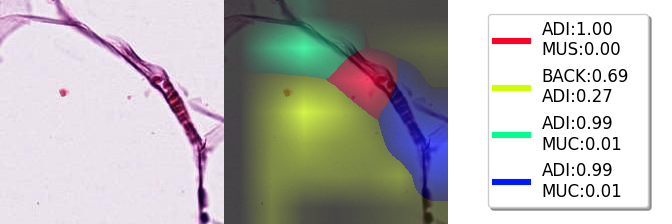

In [44]:
display(Image.fromarray(run_dff_on_image(model=model_new,
                          target_layer=target_layer,
                          classifier=model_new.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))

Text(0.5, 1.0, 'BACK')

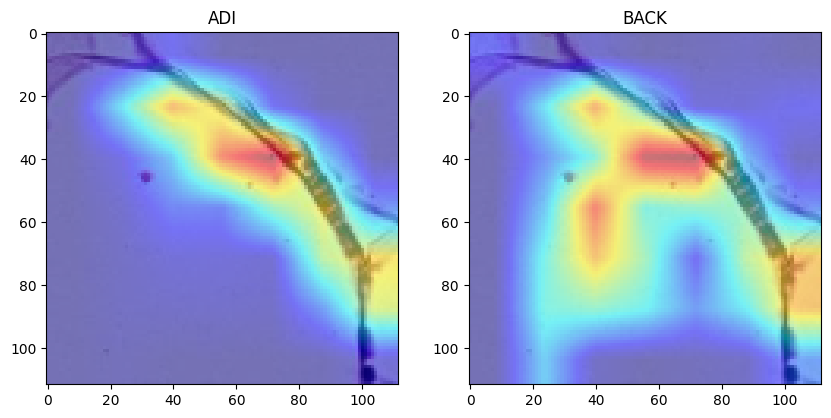

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(run_grad_cam_on_image(model=model_new,
                        target_layer=target_layer,
                        targets_for_gradcam=[ClassifierOutputTarget(category_name_to_index(model_new, "ADI"))],
                        reshape_transform=None,
                        method=GradCAMPlusPlus))
ax[0].set_title("ADI")
ax[1].imshow(run_grad_cam_on_image(model=model_new,
                        target_layer=target_layer,
                        targets_for_gradcam=[ClassifierOutputTarget(category_name_to_index(model_new, "BACK"))],
                        reshape_transform=None,
                        method=GradCAMPlusPlus))
ax[1].set_title("BACK")

Text(0.5, 1.0, 'BACK')

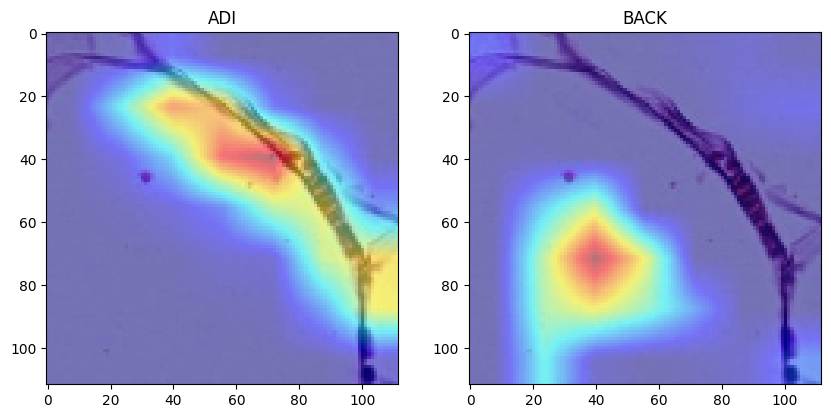

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(run_grad_cam_on_image(model=model_new,
                        target_layer=target_layer,
                        targets_for_gradcam=[ClassifierOutputTarget(category_name_to_index(model_new, "ADI"))],
                        reshape_transform=None,
                        method=GradCAM))
ax[0].set_title("ADI")
ax[1].imshow(run_grad_cam_on_image(model=model_new,
                        target_layer=target_layer,
                        targets_for_gradcam=[ClassifierOutputTarget(category_name_to_index(model_new, "BACK"))],
                        reshape_transform=None,
                        method=GradCAM))
ax[1].set_title("BACK")